<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/RNN_For_1D_Colored_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librarys

In [16]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense, LSTM, GRU, RNN,SimpleRNN
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from datetime import datetime # for put the time info in each plot          #https://stackoverflow.com/questions/415511/how-to-get-the-current-time-in-python

# Data

## Downloading data

In [17]:
#Monting Google Drive
# https://medium.com/analytics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07
from google.colab import drive
drive.mount('/content/drive')
#Importing and conifg the Kaggle Drive
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# Acessing the folder
%cd /content/drive/MyDrive/Kaggle/
# Dowloading NASA data-set
!kaggle datasets download -d luanorionbarana/synthetic-colored-noise
#Unziping data-set
!unzip "synthetic-colored-noise.zip" -d "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kaggle
synthetic-colored-noise.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  synthetic-colored-noise.zip
replace /content/color.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/color.plk? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [18]:
#Retorning to Sample folder! NOT NECESSERY
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content


In [19]:
df = pd.read_pickle('color.plk')

ValueError: ignored

## Data Normalization

In [ ]:
#NORMALIZING THE DATA
#Creating a vector with the coloumns name
columns = df.columns[1:]
#Loop for all the collus
for j in range(len(columns)):
    data=[]
    for i in range(len(df[columns[j]])):
        #reshaping the time series for a format that every single value inside the list is a vector, 
        #that will make a matrix with 1 column e 6k lines.
        x = np.reshape(df[columns[j]][i],(len(df[columns[j]][0]),1))
        #normalizing using `MaxAbsScaler`. 
        #That line will search for the Max VECTOR inside a list of vector and use for the 
        #normalizartion. That can correctly work for negative numbers when all the values in the
        #"dataframe is vectors"
        norm = preprocessing.MaxAbsScaler().fit(x).transform(x)
        #Reshaping the normalization vector for vector in the same original format
        #We want 1 vector with 6k data, not 1 vecto with 6k vectors
        y = np.reshape(norm,(1,len(df[columns[j]][i])))
        #alocating these value in a data vector
        data.append(list(y[0]))
    #realocating theses normalized data in the dataframe
    df[columns[j]] = data
    del data



In [ ]:
# # Scaling the training set
# sc = MinMaxScaler(feature_range=(0,1))
# training_set_scaled = sc.fit_transform(training_set)

Text(0, 0.5, 'Amplitude')

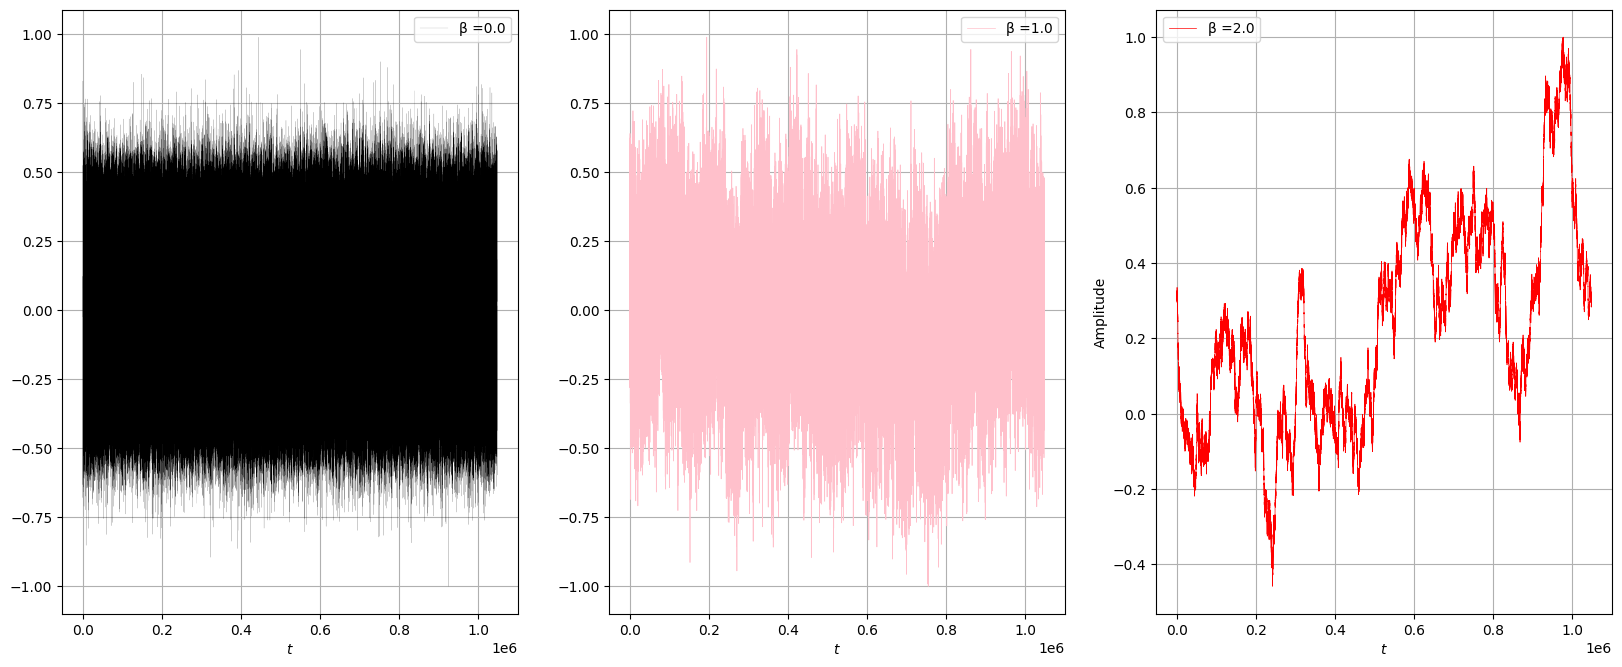

In [ ]:
index = [0,40,80]
color = ['black','pink','red']
linewidth = [0.07,0.5,.5]
plt.figure(figsize=(20,8),dpi=100)
for i in range(len(index)):
  plt.subplot(1,3,i+1)
  plt.plot(df.Series[index[i]][:],label='β ='+str(df.beta[index[i]]),color=color[i],linewidth=linewidth[i])
  plt.grid()
  plt.legend()
  plt.xlabel('$t$')
plt.ylabel('Amplitude')
  #plt.title(color[i]+ ' noise')
#plt.suptitle('Colored Noise')


# Pre-processing

In [ ]:
len(df.Series[0])

1048576

In [ ]:
#serie_index = 0  #white Noise
#serie_index = 40 #pink noise
serie_index =  81#red Noise

min_size , max_size = 0 , len(df.Series[0])

dataframe = pd.DataFrame({"Serie":df['Series'][serie_index][min_size:max_size]})
dataset = dataframe.values.astype('float32')
beta = str(df['beta'][serie_index])

In [ ]:
# definindo as amostras de treinamento e teste segundo o hold-out.
train_size = int(len(dataset) * 0.50)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#val_size = 5000
#train, test, val = dataset[0:train_size,:], dataset[train_size:len(dataset),:], dataset[len(dataset):len(dataset)+val_size,:]

In [ ]:
np.shape(val)

(0, 1)

In [ ]:
# conversão da série temporal em uma matriz de atributos para regressão
def create_dataset(dataset, look_back=10):
	'''
  Essa função irá criar dois vetores, dataX e dataY, o dataX irá conter um conjuntos de números dentro da série temporal
  e o dataY será o seu valor a posteriorí

  Por ex: 
  lista = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  se o look_back for igual a 3 teremos 
  dataX[0] = [0,1,2] ; dataY[0] = [3]
  dataX[1] = [1,2,3] ; dataY[1] = [4]
  dataX[2] = [2,3,4] ; dataY[2] = [5]
  dataX[3] = [3,4,5] ; dataY[3] = [6]
  ...
	'''
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1000
trainX, trainY = create_dataset(train, look_back)
testX, testY   = create_dataset(test,  look_back)
#valX, valY     = create_dataset(val,   look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX,(trainX.shape[0],1, trainX.shape[1]))
testX =  np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#valX =   np.reshape(valX,  (valX.shape[0],  1, valX.shape[1]))

# Model

In [ ]:
#Setting Random seeds🌱
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(3)

In [ ]:
model_RNN = Sequential()
model_RNN.add(SimpleRNN(4, input_shape=(1, look_back)))
model_RNN.add(Dense(1))
model_RNN.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_RNN = model_RNN.fit(trainX, trainY, epochs=150, batch_size=len(trainX), verbose=0,validation_split=0.7)

model_LSTM = Sequential()
model_LSTM.add(LSTM(4, input_shape=(1, look_back)))
model_LSTM.add(Dense(1))
model_LSTM.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_LSTM = model_LSTM.fit(trainX, trainY, epochs=150, batch_size=len(trainX), verbose=0,validation_split=0.7)

model_GRU = Sequential()
model_GRU.add(GRU(4, input_shape=(1, look_back)))
model_GRU.add(Dense(1))
model_GRU.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_GRU = model_GRU.fit(trainX, trainY, epochs=150, batch_size=len(trainX), verbose=0,validation_split=0.7)


In [ ]:
#Alocationg all the models in vectors!
model = [model_RNN,model_LSTM,model_GRU]
history = [history_RNN,history_LSTM,history_GRU]
model_name = ['RNN','LSTM','GRU']
color = ['C0','C1','C2']

#Allocating metrics
loss, mse, val_loss =[],[],[]
for i in range(len(model)):
  loss.append(history[i].history['loss'])
  mse.append(history[i].history['mse'])
  val_loss.append(history[i].history['val_loss'])

# Model Results

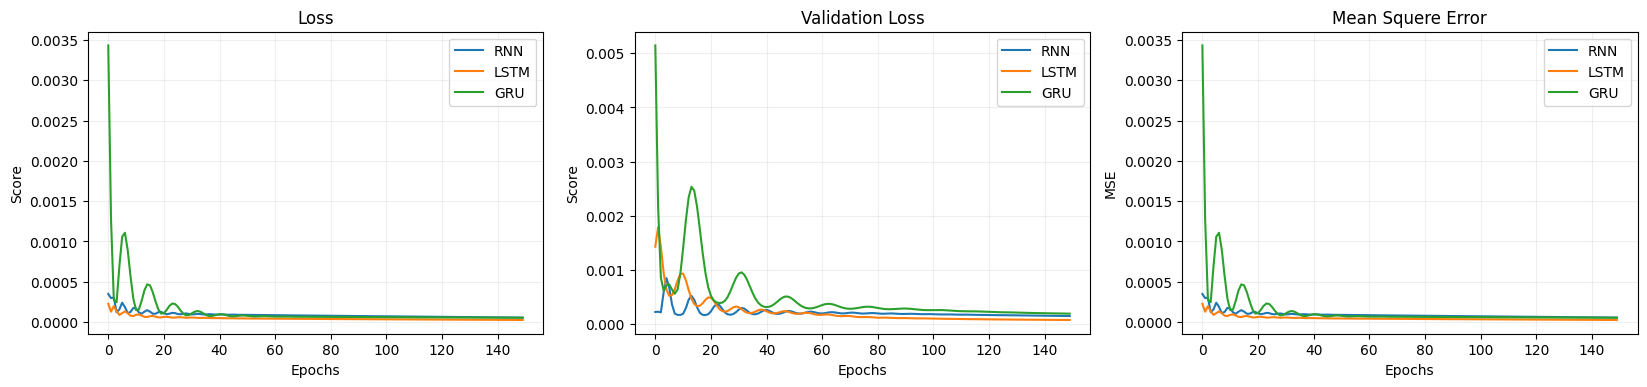

In [ ]:
epochs = np.arange(0,len(loss[0]))
plt.figure(figsize=(20, 4),dpi=100)

plt.subplot(1,3,1)
for i in range(len(model)): plt.plot(epochs,loss[i], label=model_name[i],  color=color[i], linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Loss')
plt.grid(alpha=0.2)

plt.subplot(1,3,2)
for i in range(len(model)): plt.plot(epochs,val_loss[i], label=model_name[i],  color=color[i], linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Validation Loss')
plt.grid(alpha=0.2)


plt.subplot(1,3,3)
for i in range(len(model)): plt.plot(epochs,mse[i], label=model_name[i],  color=color[i], linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title("Mean Squere Error")
plt.grid(alpha=0.2)

plt.show()

In [ ]:
# make predictions
i=0
trainPredict = model[i].predict(trainX)
testPredict  = model[i].predict(testX)
valPredict   = model[i].predict(valX)

# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY1[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY1[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

'''
For plot this that its very important to shift the predicthat data. 
The trainPredict will stat from look_back+1 that is happing beacouse the first
look_back points was used to generate de look_back+1 data
'''

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
#We done that for the plot could start on the point of and the traing data
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

valPredictPlot = np.empty([len(dataset)+len(val),1])
valPredictPlot[:, :] = np.nan
valPredictPlot[len(dataset):len(dataset)+len(valPredict), :] = valPredict

# plot baseline and predictions
model_data =  np.empty_like(dataset) #creating a empyt vector
model_data[look_back:len(trainPredict)+look_back, :] = trainPredict #alocating the the train data generatead by the model
model_data[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict #alocating the the test data generatead by the model
model_data = (np.reshape(model_data,(len(model_data))))
model_data[:look_back] = np.nan
#model_data = model_data[look_back:]

# Killing divergences
for i in range(len(model_data)):
    if model_data[i] > 1: model_data[i] = numpy.nan
    #if model_data[i] < 0.0001: model_data[i] = 0


In [ ]:
# # make predictions
# trainPredict = model.predict(trainX)
# testPredict  = model.predict(testX)
# # trainY1      =([trainY])
# # testY1       =([testY])

# # # calculate root mean squared error
# # trainScore = math.sqrt(mean_squared_error(trainY1[0], trainPredict[:,0]))
# # print('Train Score: %.2f RMSE' % (trainScore))
# # testScore = math.sqrt(mean_squared_error(testY1[0], testPredict[:,0]))
# # print('Test Score: %.2f RMSE' % (testScore))

# # shift train predictions for plotting
# trainPredictPlot = numpy.empty_like(dataset)
# trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# # plot baseline and predictions
# model_data =  numpy.empty_like(dataset) #creating a empyt vector
# model_data[look_back:len(trainPredict)+look_back, :] = trainPredict #alocating the the traint data generatead by the model
# model_data[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict #alocating the the test data generatead by the model
# model_data = (np.reshape(model_data,(len(model_data))))
# model_data[:look_back] = numpy.nan
# #model_data = model_data[look_back:]

# # Killing divergences
# for i in range(len(model_data)):
#     if model_data[i] > 1: model_data[i] = numpy.nan
#     #if model_data[i] < 0.0001: model_data[i] = 0


AttributeError: ignored

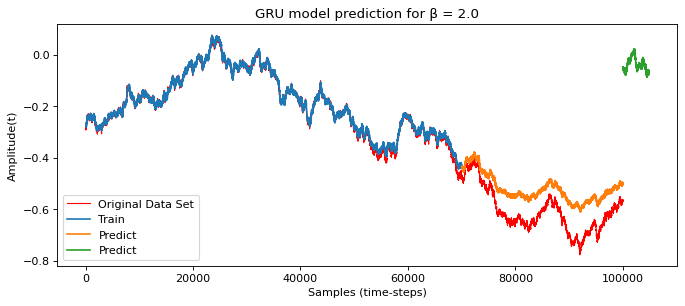

In [ ]:
if   beta == '0.0': df_color = 'black'
elif beta == '1.0': df_color = 'magenta'
else              : df_color = 'red'

grossura = 0.5 if beta == '0.0' else 1

time = "EOSBF_"
plt.figure(figsize = (10,4), dpi=80)
plt.plot(dataset,label="Original Data Set",color = df_color,linewidth=grossura)
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Predict')
plt.plot(valPredictPlot,label='Predict')
plt.title(str(modelo_nome)+' model prediction for β = '+str(beta))
#plt.plot(model_data,linestyle='--',linewidth=0.4)
#plt.plot(x,df['Series'][serie_index][max_size:max_size+len(x)])
plt.ylabel('Amplitude(t)')
plt.xlabel('Samples (time-steps)')
plt.legend()
#plt.savefig(time+'Results_beta_'+beta+'model_'+modelo_nome+'lookback_'+str(look_back)+'npoins_'+str(max_size+min_size)+".png")
plt.savefig(beta+'_'+modelo_nome+'Model_Pred.png')
#plt.xlim(0,20)
plt.show()

In [ ]:
#Alocating these results in a dataframe
df_time =  pd.DataFrame(dataset[:2**int(np.log2(len(dataset)))])
df_model = pd.DataFrame(model_data[:2**int(np.log2(len(model_data)))])

#Creating and save has a CSV
df_time.to_csv("time.csv", index=False, header=False)
df_model.to_csv("model.csv", index=False, header=False)

#Generate 
time_series = list(np.reshape(dataset,(1,len(dataset)))[0])
data_model = list(model_data)
df_final = pd.DataFrame({"time_series":time_series,"model_data":data_model})

modelos = 'LSTM' if str(modelo)[-6:-2] else 'GRU'
#time = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S')).replace(":","_")    
time = "EOSBF_"
df_final.to_csv(time+'beta_'+beta+'model_'+modelos+'lookback_'+str(look_back)+'npoins_'+str(max_size+min_size)+".csv")

#csv_para_txt
import csv
with open("serie_time.txt", "w") as my_output_file: 
    with open("time.csv", "r") as my_input_file: [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

with open("model_data.txt", "w") as my_output_file: 
    with open("model.csv", "r") as my_input_file: [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()
#

In [ ]:
############################################################################
# #The following lines its a code provid by Reinaldo Rosa called SpecPlus.
# #the original code is on google colab. Here, is just a resume
############################################################################



def specplus(nomeArquivo):
    cor = 'black' if nomeArquivo == 'serie_time.txt' else 'C0'

    titulo =  'Original Time Series Data' if nomeArquivo == 'serie_time.txt'  else 'Model Time Series Data'


    import matplotlib.pyplot as plt
    import matplotlib.mlab as mlab
    from scipy import stats, optimize
    import numpy as np
    import math
    __authors__ = 'Paulo Giovani & Reinaldo Rosa'
    __copyright__ = 'Copyright 2017, 3DBMO Project INPE'
    __credits__ = ['Paulo Giovani', 'Reinaldo Roberto Rosa', 'Murilo da Silva Dantas']
    __license__ = 'GPL'
    __version__ = '0.1B'
    __maintainer__ = 'Paulo Giovani'
    __email__ = 'pg_faria@yahoo.com.br'
    time = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S')).replace(":","_")    
    #---------------------------------------------------------------------
    # Calcula o PSD da série temporal
    #---------------------------------------------------------------------
    def psd(data):
        """Calcula o PSD de uma série temporal."""
        # Define um intervalo para realizar o ajuste da reta
        INICIO = 15
        FIM = 6300
        # O vetor com o tempo é o tamanho do número de pontos
        N = len(data)
        tempo = np.arange(len(data))
        # Define a frequência de amostragem
        dt = (tempo[-1] - tempo[0] / (N - 1))
        fs = 1 / dt
        # Calcula o PSD utilizando o MLAB
        power, freqs = mlab.psd(data, Fs = fs, NFFT = N, scale_by_freq = False)
        # Calcula a porcentagem de pontos utilizados na reta de ajuste
        totalFrequencias = len(freqs)
        totalPSD = FIM - INICIO
        porcentagemPSD = int(100 * totalPSD / totalFrequencias)
        # Seleciona os dados dentro do intervalo de seleção
        xdata = freqs[INICIO:FIM]
        ydata = power[INICIO:FIM]
        # Simula o erro
        yerr = 0.2 * ydata
        # Define uma função para calcular a Lei de Potência
        powerlaw = lambda x, amp, index: amp * (x**index)
        # Converte os dados para o formato LOG
        logx = np.log10(xdata)
        logy = np.log10(ydata)
        # Define a função para realizar o ajuste
        fitfunc = lambda p, x: p[0] + p[1] * x
        errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err    
        logyerr = yerr / ydata
        # Calcula a reta de ajuste
        pinit = [1.0, -1.0]
        out = optimize.leastsq(errfunc, pinit, args = (logx, logy, logyerr), full_output = 1)    
        pfinal = out[0]
        covar = out[1]
        index = pfinal[1]
        amp = 10.0 ** pfinal[0]
        indexErr = np.sqrt(covar[0][0])
        ampErr = np.sqrt(covar[1][1]) * amp
        # Retorna os valores obtidos
        return freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM

    #---------------------------------------------------------------------
    # Calcula o DFA 1D da série temporal
    #---------------------------------------------------------------------

    def dfa1d(timeSeries, grau):
        """Calcula o DFA 1D (adaptado de Physionet), onde a escala cresce
        de acordo com a variável 'Boxratio'. Retorna o array 'vetoutput', 
        onde a primeira coluna é o log da escala S e a segunda coluna é o
        log da função de flutuação."""
        # 1. A série temporal {Xk} com k = 1, ..., N é integrada na chamada função perfil Y(k)
        x = np.mean(timeSeries)
        timeSeries = timeSeries - x
        yk = np.cumsum(timeSeries)
        tam = len(timeSeries)
        # 2. A série (ou perfil) Y(k) é dividida em N intervalos não sobrepostos de tamanho S
        sf = np.ceil(tam / 4).astype(np.int)
        boxratio = np.power(2.0, 1.0 / 8.0)
        vetoutput = np.zeros(shape = (1,2))
        s = 4
        while s <= sf:        
            serie = yk        
            if np.mod(tam, s) != 0:
                l = s * int(np.trunc(tam/s))
                serie = yk[0:l]			
            t = np.arange(s, len(serie), s)
            v = np.array(np.array_split(serie, t))
            l = len(v)
            x = np.arange(1, s + 1)
            # 3. Calcula-se a variância para cada segmento v = 1,…, n_s:
            p = np.polynomial.polynomial.polyfit(x, v.T, grau)
            yfit = np.polynomial.polynomial.polyval(x, p)
            vetvar = np.var(v - yfit)
    # 4. Calcula-se a função de flutuação DFA como a média das variâncias de cada intervalo
            fs = np.sqrt(np.mean(vetvar))
            vetoutput = np.vstack((vetoutput,[s, fs]))
            # A escala S cresce numa série geométrica
            s = np.ceil(s * boxratio).astype(np.int)
        # Array com o log da escala S e o log da função de flutuação   
        vetoutput = np.log10(vetoutput[1::1,:])
        # Separa as colunas do vetor 'vetoutput'
        x = vetoutput[:,0]
        y = vetoutput[:,1]
        # Regressão linear
        slope, intercept, _, _, _ = stats.linregress(x, y)
        # Calcula a reta de inclinação
        predict_y = intercept + slope * x
        # Calcula o erro
        pred_error = y - predict_y
        # Retorna o valor do ALFA, o vetor 'vetoutput', os vetores X e Y,
        # o vetor com os valores da reta de inclinação e o vetor de erros
        return slope, vetoutput, x, y, predict_y, pred_error
    #---------------------------------------------------------------------
    # Trecho principal
    #---------------------------------------------------------------------
    def main():
        """Função com o código principal do programa."""
        #print("\nSpectral Analysis for time series...\n")
        # Desabilita as mensagens de erro do Numpy (warnings)
        old_settings = np.seterr(divide = 'ignore', invalid = 'ignore', over = 'ignore')
        # Carrega o arquivo de dados
        #nomeArquivo = 'serie1.txt'		
        data = np.genfromtxt(nomeArquivo,
                             delimiter = ',',
                             dtype = 'float32',
                             filling_values = 0)
        # Exibe os primeiro N valores do arquivo
        N = 10
        #print("Original time series data (%d points): \n" %(len(data)))
        #print("First %d points: %s\n" %(N, data[0:10]))
        #print()
        #-----------------------------------------------------------------
        # Parâmetros gerais de plotagem
        #-----------------------------------------------------------------
        # Define os subplots
        fig = plt.figure(figsize=(6,4), dpi=100)
        fig.subplots_adjust(hspace = .4, wspace = .2)
        # Tamanho das fontes
        tamanhoFonteEixoX     = 16
        tamanhoFonteEixoY     = 20
        tamanhoFonteTitulo    = 16
        tamanhoFontePrincipal = 25
        # Título principal
        tituloPrincipal = 'Time Series Spectral Analysis' 	
        #-----------------------------------------------------------------
        # Plotagem da série original
        #-----------------------------------------------------------------
        # Define as cores da plotagem
        corSerieOriginal = cor# 'r'
        # Título dos eixos da série original
        textoEixoX = 'Time'
        textoEixoY = 'Amplitude'
        textoTituloOriginal = titulo
        #print("1. Plotting time series data...")
        # Plotagem da série de dados    
        #O = fig.add_subplot(1, 3, 1)    
        # O = fig.add_subplot(2, 1, 1)
        # O.plot(data, '-', color = corSerieOriginal)
        # O.set_title(textoTituloOriginal, fontsize = tamanhoFonteTitulo)
        # O.set_xlabel(textoEixoX, fontsize = tamanhoFonteEixoX)
        # O.set_ylabel(textoEixoY, fontsize = tamanhoFonteEixoY)
        # O.ticklabel_format(style = 'sci', axis = 'x', scilimits = (0,0))
        # O.grid()
        #-----------------------------------------------------------------
        # Cálculo e plotagem do PSD                                     --
        #-----------------------------------------------------------------
        # Calcula o PSD
        freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = psd(data)
        # O valor do beta equivale ao index
        b = index
        # Define as cores da plotagem
        corPSD1 = 'k'
        #corPSD2 =  'orange' if modelo_nome == 'GRU' else 'green'
        corPSD2 =  'navy' if nomeArquivo == 'serie_time.txt' else 'orange' if modelo_nome == 'GRU' else 'green'
        # Título dos eixos do PSD
        textoPSDX = 'Frequency (Hz)'
        textoPSDY = 'PSD'
        #textoTituloPSD = r''+str(modelo_nome)+' - PSD Estimation β = '
        textoTituloPSD = r'Original Time Series - PSD Estimation β = ' if nomeArquivo == 'serie_time.txt' else r'GRU - PSD Estimation β = ' if modelo_nome == 'GRU' else r'LSTM - PSD Estimation β = '
        #print("2. Plotting Power Spectrum Density...")
        # Plotagem do PSD    
        PSD = fig.add_subplot(2, 2, (1,4))    
        PSD.plot(freqs, power, '-', color = corPSD1, alpha = 0.7)
        PSD.plot(xdata, ydata, color = corPSD2, alpha = 0.8)
        PSD.axvline(freqs[INICIO], color = corPSD2, linestyle = '--')
        PSD.axvline(freqs[FIM], color = corPSD2, linestyle = '--')    
        PSD.plot(xdata, powerlaw(xdata, amp, index), 'r-', linewidth = 1.5, label = '$%.4f$' %(b))    
        PSD.set_xlabel(textoPSDX                                  )#, fontsize = tamanhoFonteEixoX)
        PSD.set_ylabel(textoPSDY                                  )#, fontsize = tamanhoFonteEixoY)
        PSD.set_title(textoTituloPSD + '%.4f' %(b), loc = 'center')#, fontsize = tamanhoFonteTitulo)
        PSD.set_yscale('log')
        PSD.set_xscale('log')
        PSD.grid() 
        #-----------------------------------------------------------------
        # Cálculo e plotagem do DFA
        #-----------------------------------------------------------------
        # Calcula o DFA 1D
        alfa, vetoutput, x, y, reta, erro = dfa1d(data, 1)
        # Verifica se o DFA possui um valor válido
        # Em caso afirmativo, faz a plotagem
        # if not math.isnan(alfa):
        # 	# Define as cores da plotagem
        # 	corDFA = 'darkmagenta'
        # 	# Título dos eixos do DFA
        # 	textoDFAX = '$log_{10}$ (s)'
        # 	textoDFAY = '$log_{10}$ F(s)'
        # 	textoTituloDFA = r'Detrended Fluctuation Analysis $\alpha$ = '
        # 	print("3. Plotting Detrended Fluctuation Analysis...")
        # 	# Plotagem do DFA 
        # 	DFA = fig.add_subplot(2, 2, 4)    
        # 	DFA.plot(x, y, 's', 
        # 			 color = corDFA, 
        # 			 markersize = 4
        # 			 markeredgecolor = 'r',
        # 			 markerfacecolor = 'None',
        # 			 alpha = 0.8)				 
        # 	DFA.plot(x, reta, '-', color = corDFA, linewidth = 1.5)
        # 	DFA.set_title(textoTituloDFA + '%.4f' %(alfa), loc = 'center', fontsize = tamanhoFonteTitulo)
        # 	DFA.set_xlabel(textoDFAX, fontsize = tamanhoFonteEixoX)
        # 	DFA.set_ylabel(textoDFAY, fontsize = tamanhoFonteEixoY)
        # 	DFA.grid()
        # else:  
        # 	DFA = fig.add_subplot(2, 2, 4)
        # 	DFA.set_title(textoTituloDFA + 'N.A.', loc = 'center', fontsize = tamanhoFonteTitulo)
        # 	DFA.grid()
        #-----------------------------------------------------------------
        # Exibe e salva a figura
        #-----------------------------------------------------------------
        #plt.suptitle(tituloPrincipal, fontsize = tamanhoFontePrincipal)
        time = "EOSBF_"
        #nomeImagem = beta+modelo_nome+time+nomeArquivo+'ANALYSIS_PSD_DFA_.png'
        nomeImagem = beta+'_'+modelo_nome+nomeArquivo+'_PSD.png'
        fig.set_size_inches(7, 4)
        plt.savefig(nomeImagem, dpi = 300, bbox_inches = 'tight', pad_inches = 0.1)	
        plt.show()
    #---------------------------------------------------------------------
    # Trecho principal
    #---------------------------------------------------------------------
    if __name__ == "__main__":
        main()
    #——————————————————————————————————————————

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

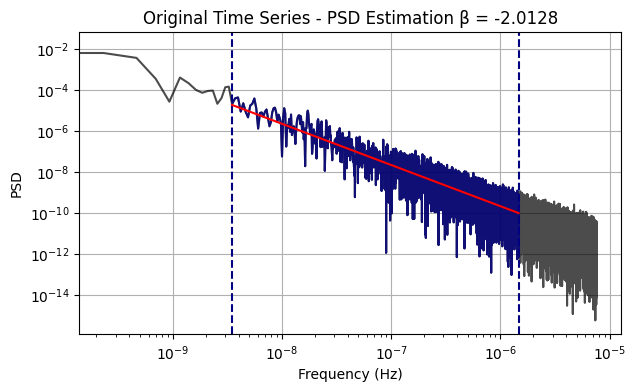

None


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

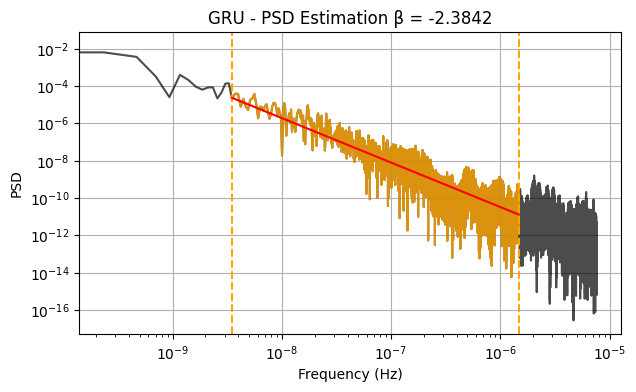

None


In [ ]:
print(specplus('serie_time.txt'))
print(specplus('model_data.txt'))

In [ ]:
#remove all
#!rm *

rm: cannot remove 'sample_data': Is a directory


In [ ]:
#Ziping Data for download📦
#!zip -r /content/All_Files.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.metricsUUID (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2022.03.23/ (stored 0%)
  adding: content/.config/logs/2022.03.23/14.22.10.115472.log (deflated 55%)
  adding: content/.config/logs/2022.03.23/14.22.11.024461.log (deflated 54%)
  adding: content/.config/logs/2022.03.23/14.21.37.874736.log (deflated 86%)
  adding: content/.config/logs/2022.03.23/14.20.51.700340.log (deflated 90%)
  adding: content/.config/logs/2022.03.23/14.21.47.434153.log (deflated 53%)
  adding: content/.config/logs/2022.03.23/14.21.15.158122.log (deflated 53%)
  adding: content/.config/.feature_flags_config.yaml (deflated 23%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.last_update_